In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define stock symbol and number of trading days
# ticker = "AAPL"  # You can change this to any other stock
ticker = "MSFT"  # Example: NVIDIA Corporation
period = "10000d"  # Request 1000 calendar days of data (adjusted for trading days)

/home/harshamupparaju/Softwares/anaconda3/envs/stock_prediction/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Download historical stock data
data = yf.download(ticker, period=period, interval="1d")

# Reset index to get 'date' column
df = data.reset_index()



df.columns = [df.columns[i][0].lower() for i in range(len(df.columns))]

df['average_sentiment'] = np.random.uniform(-1, 1, size=len(df))

# Add target column for supervised learning
df['target_price'] = df['open'].shift(-1)
df = df[:-1]  # Drop last row with NaN target

# Optional: Sort and reset index
df = df.sort_values(by='date').reset_index(drop=True)

df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,date,close,high,low,open,volume,average_sentiment,target_price
0,1986-03-13,0.059707,0.062373,0.054376,0.054376,1031788800,-0.860701,0.059707
1,1986-03-14,0.061839,0.062906,0.059707,0.059707,308160000,-0.641800,0.061839
2,1986-03-17,0.062906,0.063439,0.061839,0.061839,133171200,-0.470424,0.062906
3,1986-03-18,0.061306,0.063439,0.060773,0.062906,67766400,-0.266282,0.061306
4,1986-03-19,0.060240,0.061839,0.059707,0.061306,47894400,0.051305,0.060240


Using device: cuda


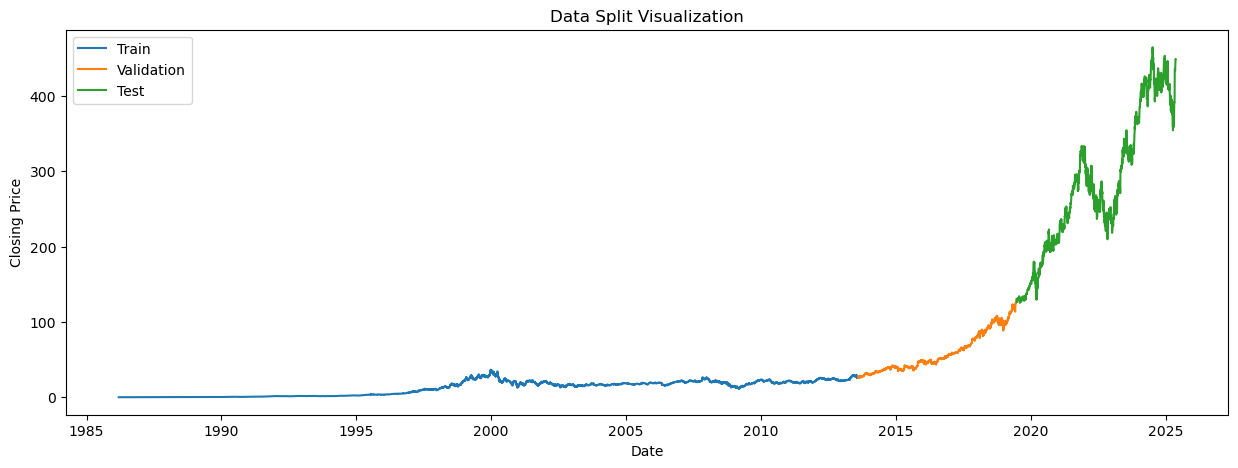

/home/harshamupparaju/Softwares/anaconda3/envs/stock_prediction/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/5], Train Loss: 0.081291, Val Loss: 3.636621
Epoch [2/5], Train Loss: 0.027421, Val Loss: 2.130667
Epoch [3/5], Train Loss: 0.011747, Val Loss: 1.344507
Epoch [4/5], Train Loss: 0.009740, Val Loss: 0.847174
Epoch [5/5], Train Loss: 0.007637, Val Loss: 0.397124


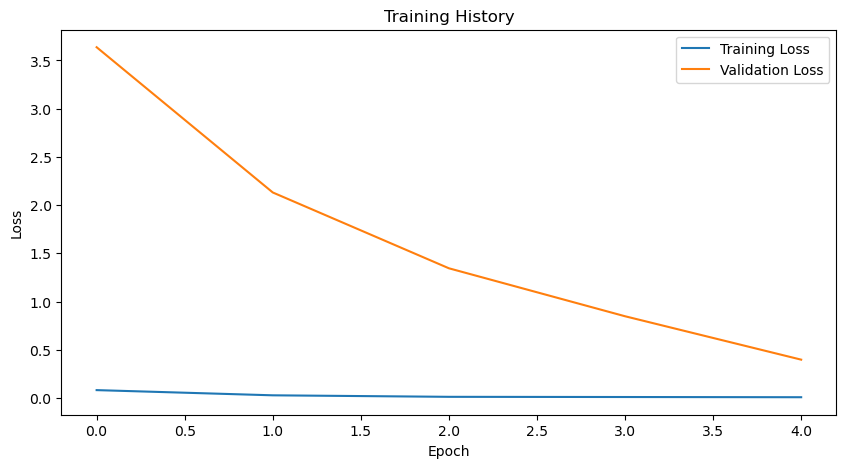

Test MSE: 9346.4935
Test MAE: 90.1488
Test MAPE: 30.85%


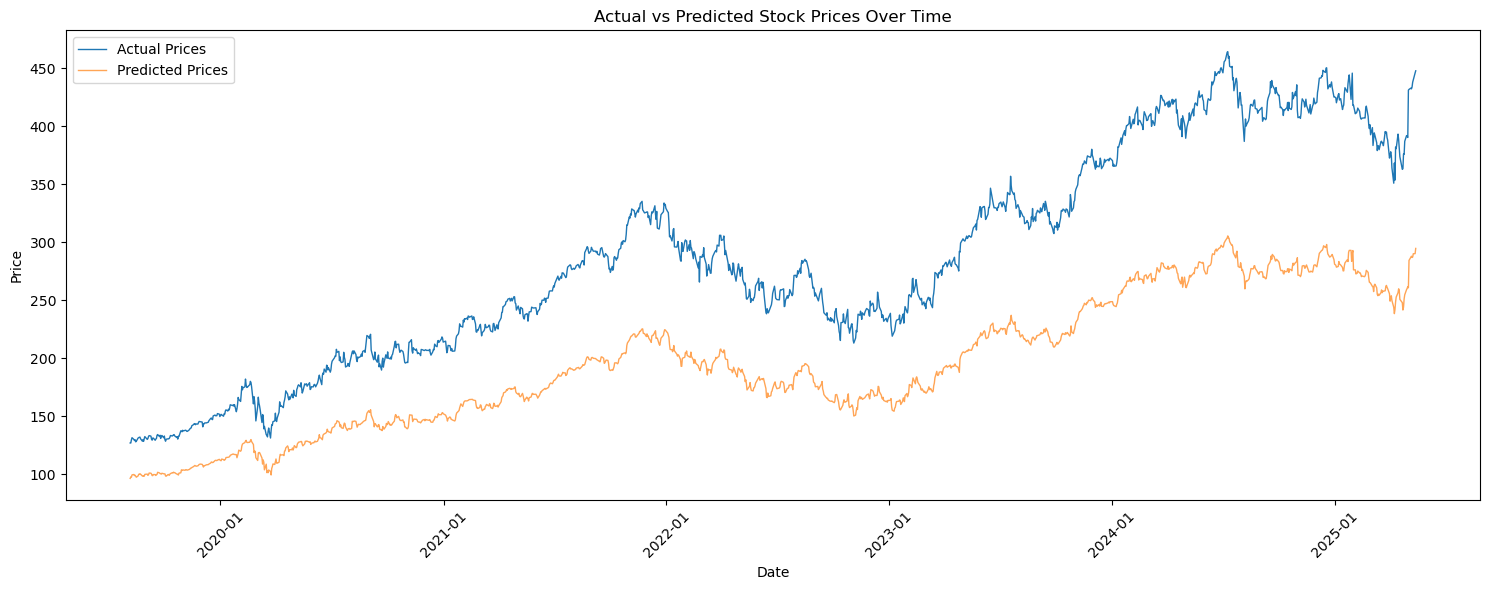

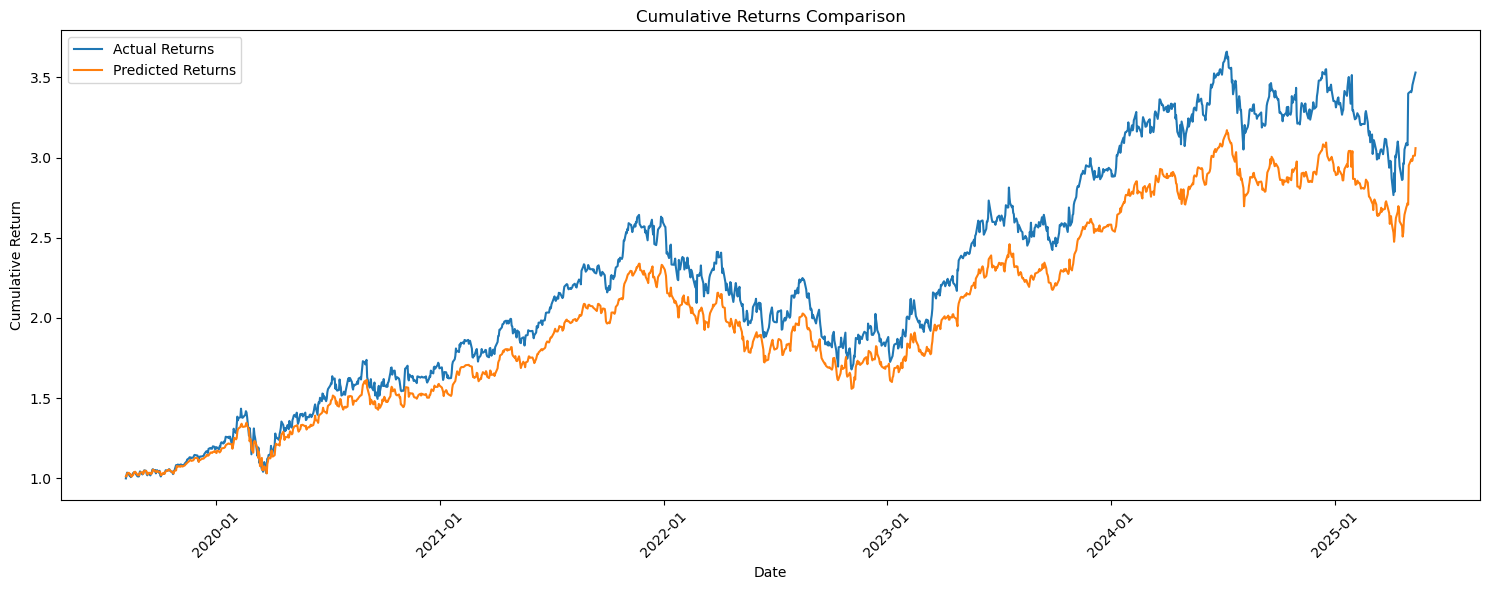

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Enhanced Data Preparation with Temporal Integrity
class TemporalStockDataset(Dataset):
    def __init__(self, df, sequence_length=30, feature_scaler=None, target_scaler=None, mode='train'):
        self.sequence_length = sequence_length
        self.mode = mode
        self.dates = df['date'].values
        
        features = ['open', 'high', 'low', 'close', 'volume', 
                    'average_sentiment']
        target = ['target_price']
        
        if mode == 'train':
            self.feature_scaler = MinMaxScaler(feature_range=(-1, 1))
            self.target_scaler = MinMaxScaler(feature_range=(-1, 1))
            self.scaled_features = self.feature_scaler.fit_transform(df[features])
            self.scaled_target = self.target_scaler.fit_transform(df[target])
        else:
            if feature_scaler is None or target_scaler is None:
                raise ValueError("For validation/test, must provide pre-fit feature and target scalers")
            self.feature_scaler = feature_scaler
            self.target_scaler = target_scaler
            self.scaled_features = self.feature_scaler.transform(df[features])
            self.scaled_target = self.target_scaler.transform(df[target])
        
    def __len__(self):
        return len(self.scaled_features) - self.sequence_length
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError
            
        # Corrected target index to align with next day's open price
        x = self.scaled_features[idx:idx+self.sequence_length]
        y = self.scaled_target[idx + self.sequence_length - 1]  # Adjusted here
        
        return torch.FloatTensor(x).to(device), torch.FloatTensor(y).to(device)
    
    def get_dates(self, idx):
        return self.dates[idx:idx+self.sequence_length+1]


# 2. Model Architecture (unchanged)
class StockSentimentModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockSentimentModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc1 = nn.Linear(hidden_size + input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_last_out = lstm_out[:, -1, :]
        current_features = x[:, -1, :]
        
        combined = torch.cat((lstm_last_out, current_features), dim=1)
        
        out = self.fc1(combined)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out

# 3. Enhanced Training with Temporal Validation
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Validation
        val_loss = validate_model(model, val_loader, criterion)
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
        
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Load best model
    model.load_state_dict(best_model)
    return model

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# 4. Enhanced Evaluation with Temporal Plots
def evaluate_model(model, test_loader, test_dataset):
    model.eval()
    actuals = []
    predictions = []
    dates = []
    
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(test_loader):
            outputs = model(batch_x)
            
            # Inverse transform
            actual = test_dataset.target_scaler.inverse_transform(batch_y.cpu().numpy())
            pred = test_dataset.target_scaler.inverse_transform(outputs.cpu().numpy())
            
            actuals.extend(actual.flatten())
            predictions.extend(pred.flatten())
            
            # Get corresponding dates
            seq_end = i + test_dataset.sequence_length
            if seq_end < len(test_dataset.dates):
                target_date = test_dataset.dates[seq_end]
                dates.append(pd.to_datetime(target_date))
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    print(f'Test MSE: {mse:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test MAPE: {mape:.2f}%')
    
    # Plot actual vs predicted with dates
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actuals, label='Actual Prices', linewidth=1)
    plt.plot(dates, predictions, label='Predicted Prices', alpha=0.7, linewidth=1)
    plt.title('Actual vs Predicted Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    
    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot cumulative returns
    actual_returns = pd.Series(actuals).pct_change().dropna()
    pred_returns = pd.Series(predictions).pct_change().dropna()
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates[1:], (1 + actual_returns).cumprod(), label='Actual Returns')
    plt.plot(dates[1:], (1 + pred_returns).cumprod(), label='Predicted Returns')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return actuals, predictions, dates

# 5. Main Execution with Proper Temporal Splitting
def main():

    # df['target_price'] = df['open'].shift(-1)
    # df = df[:-1]  # Drop last row with NaN target
    
    # # Convert date to datetime and sort
    # df['date'] = pd.to_datetime(df['date'])
    # df = df.sort_values('date').reset_index(drop=True)
    
    # Strict temporal split (70/15/15)
    n = len(df)
    train_end = int(0.7 * n)
    val_end = train_end + int(0.15 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]
    
    # Plot data splits
    plt.figure(figsize=(15, 5))
    plt.plot(train_df['date'], train_df['close'], label='Train')
    plt.plot(val_df['date'], val_df['close'], label='Validation')
    plt.plot(test_df['date'], test_df['close'], label='Test')
    plt.title('Data Split Visualization')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Create datasets with proper scaling
    sequence_length = 30
    train_dataset = TemporalStockDataset(train_df, sequence_length, mode='train')
    
    val_dataset = TemporalStockDataset(
        val_df, sequence_length, 
        feature_scaler=train_dataset.feature_scaler,
        target_scaler=train_dataset.target_scaler,
        mode='val'
    )
    test_dataset = TemporalStockDataset(
        test_df, sequence_length,
        feature_scaler=train_dataset.feature_scaler,
        target_scaler=train_dataset.target_scaler,
        mode='test'
    )

    
    # Create data loaders (NO SHUFFLING)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Single-step prediction
    
    # Initialize model
    input_size = 6  # 5 features + 1 sentiment
    hidden_size = 64
    num_layers = 2
    output_size = 1
    
    model = StockSentimentModel(input_size, hidden_size, num_layers, output_size).to(device)
    
    # Train model
    num_epochs = 5
    learning_rate = 0.001
    model = train_model(model, train_loader, val_loader, num_epochs, learning_rate)
    
    # Evaluate model
    actuals, predictions, dates = evaluate_model(model, test_loader, test_dataset)
    
    # Save model
    torch.save(model.state_dict(), f'{ticker}_stock_sentiment_model.pth')

if __name__ == '__main__':
    main()